# EDA

### Public transport data

In [1]:
from google.cloud import storage
import pandas as pd
import pyarrow.parquet as pq
import io


bucket_name = "bigdata-chmurki-nifi"
client = storage.Client()

positions = []
for blob in client.list_blobs(bucket_name, prefix='warsaw'):
    if blob.name.count('Act_position') == 1:
        #date = blob.name.split("_")[2].split('-')[:-1]
        #pd.to_datetime('-'.join(date))
        #if date == today...
        
        table = pq.read_table(io.BytesIO(blob.download_as_bytes()))
        df = table.to_pandas()
        df = df.explode('vehicles').reset_index(drop=True)
        df_flat = pd.json_normalize(df['vehicles'])
        df_flat = pd.concat([df_flat, df], axis=1)
        df_flat = df_flat.drop(['vehicles'],axis=1)
        positions.append(df_flat)
        
positions_df = pd.concat(positions, ignore_index=True)

In [2]:
positions_df.head()

,generated,routeShortName,headsign,vehicleCode,vehicleService,vehicleId,speed,direction,delay,scheduledTripStartTime,lat,lon,gpsQuality,tripId.member0,tripId.member1,tripId,lastUpdate
0,2023-11-19T20:17:50Z,110,Wrzeszcz PKP,2763,110-02,145699.0,0.0,135.0,0.0,2023-11-19T20:50:00Z,54.381859,18.603849,3.0,12.0,NaN,NaN,2023-11-19T20:17:51Z
1,2023-11-19T20:17:47Z,10,Nowy Port Zajezdnia,1149,010-04,500.0,5.0,180.0,-90.0,2023-11-19T20:36:00Z,54.397491,18.673731,3.0,12.0,NaN,NaN,2023-11-19T20:17:51Z
2,2023-11-19T20:17:48Z,148,Żabianka SKM,2094,148-52,171.0,0.0,0.0,0.0,2023-11-19T20:42:00Z,54.421280,18.570271,3.0,11.0,NaN,NaN,2023-11-19T20:17:51Z
3,2023-11-19T20:17:48Z,117,"Sopot Sanatorium ""Leśnik""",8001,117-03,145659.0,0.0,180.0,0.0,2023-11-19T20:35:00Z,54.449150,18.527260,3.0,111.0,NaN,NaN,2023-11-19T20:17:51Z
4,2023-11-19T20:17:48Z,120,Port Lotniczy,2743,120-05,145600.0,35.0,180.0,44.0,2023-11-19T20:40:00Z,54.348301,18.521730,3.0,11.0,NaN,NaN,2023-11-19T20:17:51Z


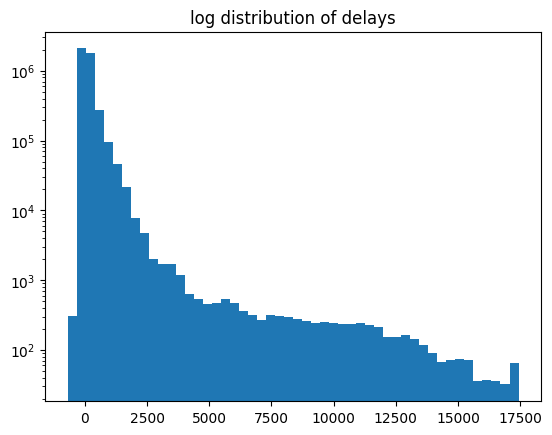

In [88]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(positions_df['delay'], bins=50, log=True)
#plt.xscale('log')
plt.title('log distribution of delays')
plt.show()

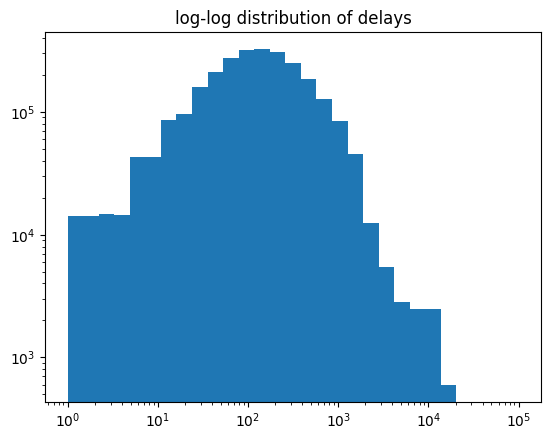

In [16]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(positions_df['delay'], bins=np.logspace(0, 5, 30), log=True)
plt.xscale('log')
plt.title('log-log distribution of delays')
plt.show()

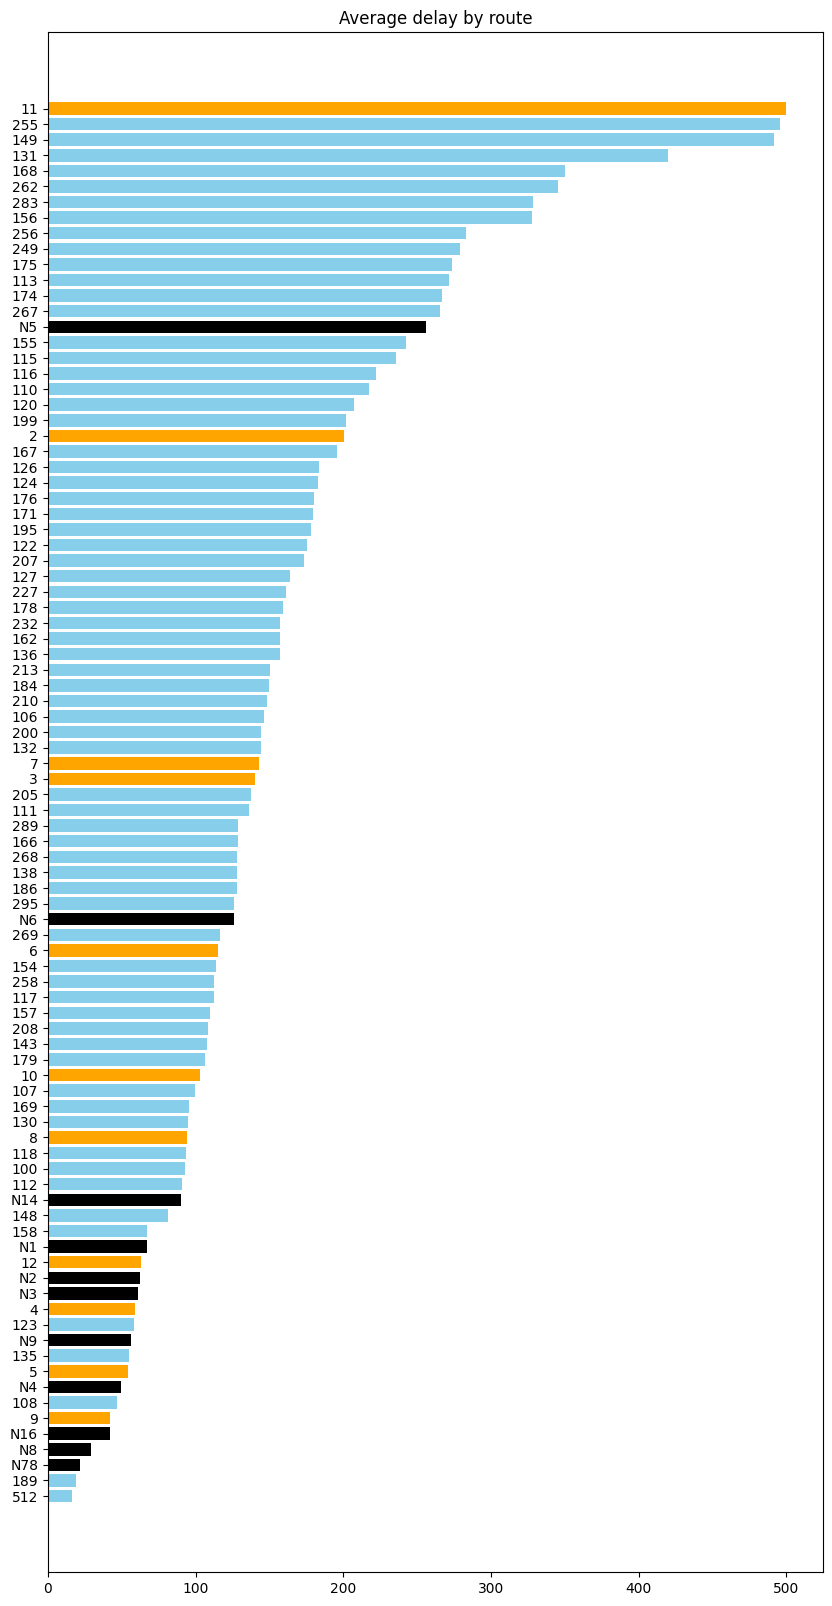

In [60]:
fig, ax = plt.subplots(figsize=(10, 20))
avg_delays = positions_df.groupby(['routeShortName'])['delay'].mean().reset_index().sort_values(['delay'])
colors = []
for route in avg_delays['routeShortName']:
    if 'N' in route:
        colors.append('black')
    elif len(route) <= 2:
        colors.append('orange')
    else:
        colors.append('skyblue')
        
bars = plt.barh(avg_delays['routeShortName'], avg_delays['delay'], color=colors)
plt.title('Average delay by route')
plt.show()

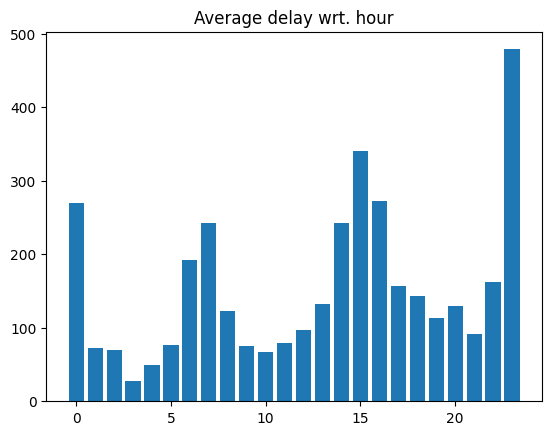

In [96]:
hour_delays = positions_df[['generated','delay']].copy()
hour_delays['generated'] = pd.to_datetime(hour_delays['generated']).dt.hour

hour_delays_grouped = hour_delays.groupby(['generated'])['delay'].mean().reset_index()
plt.bar(hour_delays_grouped['generated'],hour_delays_grouped['delay'])
plt.title('Average delay wrt. hour')
plt.show()

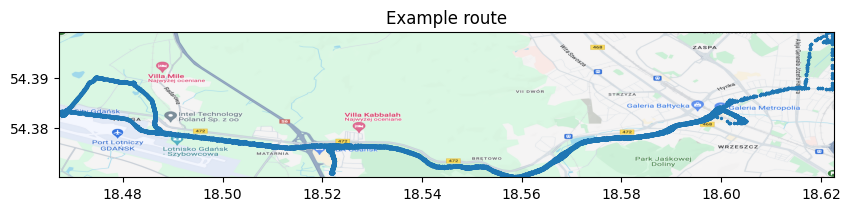

In [41]:
import matplotlib.image as mpimg
fig, ax = plt.subplots(figsize=(10, 8))

background_img = mpimg.imread('gdansk.png')

route_110 = positions_df[positions_df['routeShortName']=='110']
locations = positions_df[positions_df['routeShortName']=='110'][['lat','lon','generated']].sort_values('generated')


ax.imshow(background_img, extent=[locations['lon'].min(), locations['lon'].max(), locations['lat'].min(), locations['lat'].max()])
ax.scatter(locations['lon'],locations['lat'],s=2)
plt.title('Example route')
plt.show()

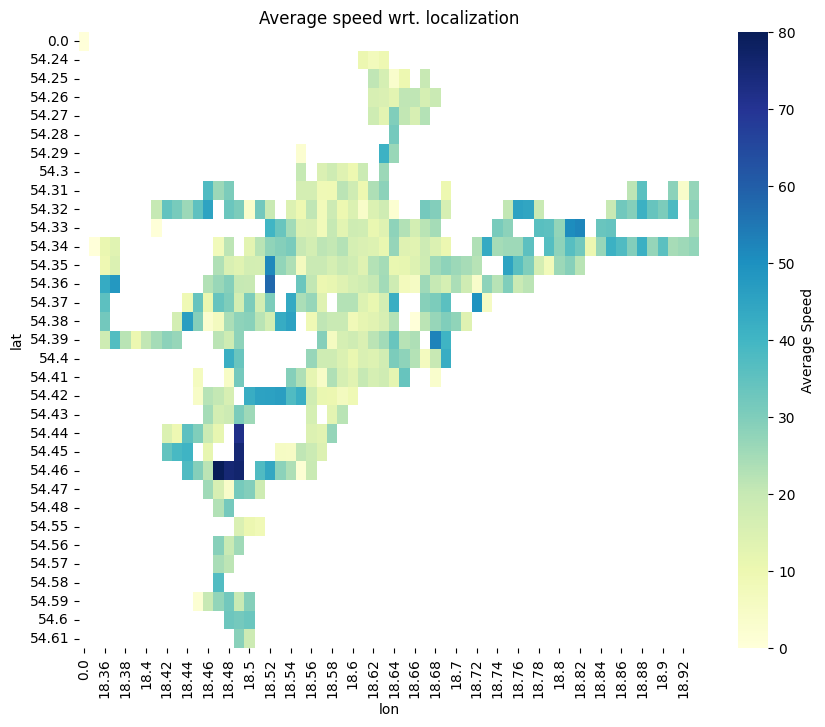

In [71]:
import seaborn as sns

speeds = positions_df[['lat','lon','speed']].copy()
speeds['lon'] = speeds['lon'].apply(lambda x: round(x,2))
speeds['lat'] = speeds['lat'].apply(lambda x: round(x,2))

speeds = speeds.groupby(['lat','lon'])['speed'].mean().reset_index()

plt.figure(figsize=(10, 8))
heatmap_data = speeds.pivot_table(index='lat', columns='lon', values='speed', aggfunc='mean')
sns.heatmap(heatmap_data, cmap='YlGnBu', fmt='.1f', cbar_kws={'label': 'Average Speed'})

plt.title('Average speed wrt. localization')
plt.show()

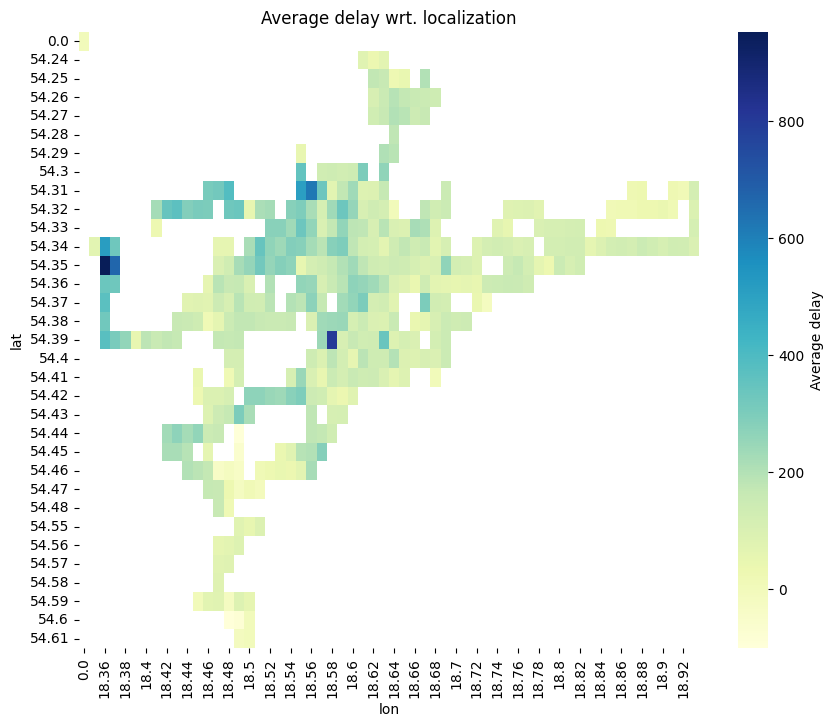

In [102]:
import seaborn as sns

delays = positions_df[['lat','lon','delay']].copy()
delays['lon'] = delays['lon'].apply(lambda x: round(x,2))
delays['lat'] = delays['lat'].apply(lambda x: round(x,2))

delays = delays.groupby(['lat','lon'])['delay'].mean().reset_index()

plt.figure(figsize=(10, 8))
heatmap_data = delays.pivot_table(index='lat', columns='lon', values='delay', aggfunc='mean')
sns.heatmap(heatmap_data, cmap='YlGnBu', fmt='.1f', cbar_kws={'label': 'Average delay'})

plt.title('Average delay wrt. localization')
plt.show()

### Weather data

In [72]:
actual = []
forecast = []

for blob in client.list_blobs(bucket_name, prefix='weather'):    
    if blob.name.count('Act') == 1:   
        table = pq.read_table(io.BytesIO(blob.download_as_bytes()))
        df = table.to_pandas()
        df_flat = pd.json_normalize(df['current'])
        #print(df_flat)
        df_flat = pd.concat([df_flat, df], axis=1)
        df_flat = df_flat.drop(['current'],axis=1)                               
        actual.append(df_flat)
    elif blob.name.count('FC'):
        table = pq.read_table(io.BytesIO(blob.download_as_bytes()))
        df = table.to_pandas()
        df_flat = pd.json_normalize(df['hourly'])
        df_flat['data'] = df_flat['data'].apply(lambda x: x[0] if x is not None and len(x) > 0 else None)
        #print(df_flat)
        df_flat = pd.json_normalize(df_flat['data'])
        df_flat = pd.concat([df_flat, df], axis=1)
        df_flat = df_flat.drop(['hourly'],axis=1)                               
        forecast.append(df_flat)
actual_df = pd.concat(actual, ignore_index=True)
forecast_df = pd.concat(forecast, ignore_index=True)
forecast_df.head()

,date,weather,icon,summary,temperature,wind.speed,wind.dir,wind.angle,cloud_cover.total,precipitation.total,precipitation.type,lat,lon,elevation,timezone,units,current,daily
0,2023-12-16T13:00:00,overcast,7,Overcast,6.2,6.1,WSW,239,95,0.0,none,54.35227N,18.64912E,18,UTC,metric,None,None
1,2023-12-16T13:00:00,overcast,7,Overcast,6.2,6.1,WSW,239,95,0.0,none,54.35227N,18.64912E,18,UTC,metric,None,None
2,2023-12-16T13:00:00,overcast,7,Overcast,6.2,6.1,WSW,239,95,0.0,none,54.35227N,18.64912E,18,UTC,metric,None,None
3,2023-12-16T14:00:00,overcast,7,Overcast,6.2,5.9,WSW,241,96,0.0,none,54.35227N,18.64912E,18,UTC,metric,None,None
4,2023-12-16T14:00:00,cloudy,6,Cloudy,6.2,5.9,WSW,241,85,0.0,none,54.35227N,18.64912E,18,UTC,metric,None,None


In [80]:
actual_df.head()

,icon,icon_num,summary,temperature,cloud_cover,wind.speed,wind.angle,wind.dir,precipitation.total,precipitation.type,lat,lon,elevation,timezone,units,hourly,daily,time
0,cloudy,6,Cloudy,5.8,87,4.7,255,WSW,0.0,none,52.22977N,21.01178E,113,UTC,metric,None,None,Sat Dec 16 14:37:21 UTC 2023
1,cloudy,6,Cloudy,5.8,87,4.7,255,WSW,0.0,none,52.22977N,21.01178E,113,UTC,metric,None,None,Sat Dec 16 14:47:21 UTC 2023
2,cloudy,6,Cloudy,5.8,87,4.7,255,WSW,0.0,none,52.22977N,21.01178E,113,UTC,metric,None,None,Sat Dec 16 14:57:21 UTC 2023
3,cloudy,6,Cloudy,5.8,88,4.5,252,WSW,0.0,none,52.22977N,21.01178E,113,UTC,metric,None,None,Sat Dec 16 14:18:22 UTC 2023
4,cloudy,6,Cloudy,5.8,88,4.5,252,WSW,0.0,none,52.22977N,21.01178E,113,UTC,metric,None,None,Sat Dec 16 14:19:10 UTC 2023


In [123]:
actual_df['time'] = pd.to_datetime(actual_df['time'])
actual_df['date'] = pd.to_datetime(actual_df['time'].dt.round('H')).dt.tz_convert('UTC')
forecast_df['date'] = pd.to_datetime(forecast_df['date']).dt.tz_localize('UTC')

In [142]:
merged_df = pd.merge(actual_df, forecast_df, left_on='rounded_time', right_on='date', suffixes=('_actual', '_forecast'))
temperature_correlation = merged_df['temperature_actual'].corr(merged_df['temperature_forecast'])
cloud_correlation = merged_df['cloud_cover'].corr(merged_df['cloud_cover.total'])
wind_correlation = merged_df['wind.speed_actual'].corr(merged_df['wind.speed_forecast'])

merged_df['summary_actual'], _ = pd.factorize(merged_df['summary_actual'])
merged_df['summary_forecast'], _ = pd.factorize(merged_df['summary_forecast'])

summary_correlation = merged_df['summary_actual'].corr(merged_df['summary_forecast'])

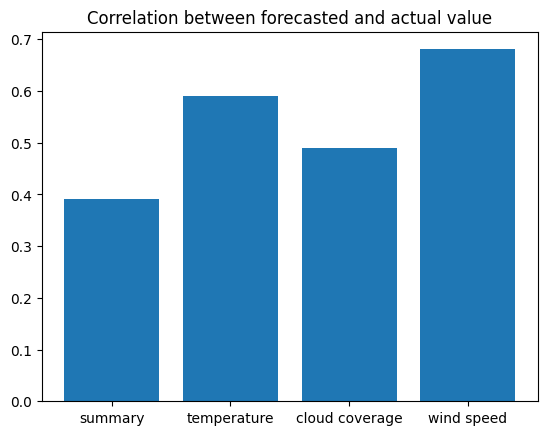

In [145]:
factors = ['summary','temperature','cloud coverage','wind speed']
values = [summary_correlation, temperature_correlation, cloud_correlation, wind_correlation]
plt.bar(factors,values)
plt.title('Correlation between forecasted and actual value')
plt.show()

In [150]:
import seaborn as sns
import matplotlib.pyplot as plt

def boxplot_distribution(df, column_name):
    plt.figure(figsize=(4, 2))
    sns.boxplot(x=df[column_name])
    plt.title(f'{column_name} distribution')
    plt.show()

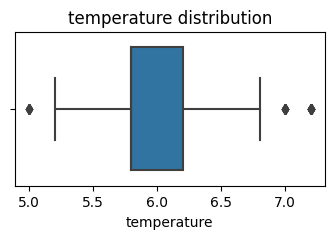

In [151]:
boxplot_distribution(actual_df,'temperature')

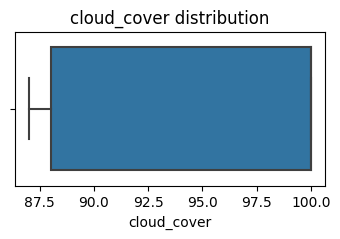

In [152]:
boxplot_distribution(actual_df,'cloud_cover')

### Other

In [29]:
import pandas as pd

# Tworzenie ramki danych z kolumną "current"
data = {'current': [{"icon": "cloudy", "icon_num": 6, "summary": "Cloudy", "temperature": 5.8,
                    "wind": {"speed": 4.5, "angle": 252, "dir": "WSW"},
                    "precipitation": {"total": 0.0, "type": "none"}, "cloud_cover": 88}]}

df = pd.DataFrame(data)

print(df)
# Normalizacja kolumny "current" i dodanie do ramki danych
df_normalized = pd.json_normalize(df['current'])

# Połączenie ramki danych pierwotnej i znormalizowanej
result_df = pd.concat([df, df_normalized], axis=1)

# Usunięcie kolumny "current", jeśli już nie jest potrzebna
result_df = result_df.drop('current', axis=1)

# Wyświetlenie wynikowej ramki danych
print(result_df)

                                             current
0  {'icon': 'cloudy', 'icon_num': 6, 'summary': '...
     icon  icon_num summary  temperature  cloud_cover  wind.speed  wind.angle  \
0  cloudy         6  Cloudy          5.8           88         4.5         252   

  wind.dir  precipitation.total precipitation.type  
0      WSW                  0.0               none  
